<a href="https://colab.research.google.com/github/Ashwitharavula/ps_lab/blob/main/ieee2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Indian_Kids_Screen_Time.csv to Indian_Kids_Screen_Time.csv
✅ Dataset 'Indian_Kids_Screen_Time.csv' loaded successfully via upload!

Dataset shape: (9712, 8)


,Age,Gender,Avg_Daily_Screen_Time_hr,Primary_Device,Exceeded_Recommended_Limit,Educational_to_Recreational_Ratio,Health_Impacts,Urban_or_Rural
0,14,Male,3.99,Smartphone,True,0.42,"Poor Sleep, Eye Strain",Urban
1,11,Female,4.61,Laptop,True,0.30,Poor Sleep,Urban
2,18,Female,3.73,TV,True,0.32,Poor Sleep,Urban
3,15,Female,1.21,Laptop,False,0.39,NaN,Urban
4,12,Female,5.89,Smartphone,True,0.49,"Poor Sleep, Anxiety",Urban



--- Training and Tuning KNN ---

📌 KNN Results
Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}
Accuracy: 97.58 %
              precision    recall  f1-score   support

       False       0.93      0.90      0.92       282
        True       0.98      0.99      0.99      1661

    accuracy                           0.98      1943
   macro avg       0.96      0.94      0.95      1943
weighted avg       0.98      0.98      0.98      1943



<Figure size 1000x700 with 0 Axes>

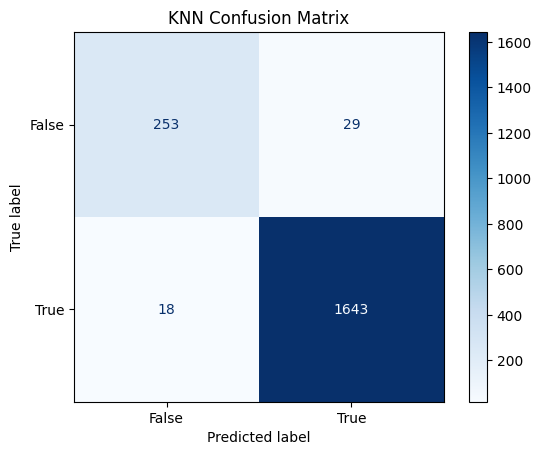


--- Training and Tuning SVM ---

📌 SVM Results
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 98.51 %
              precision    recall  f1-score   support

       False       0.97      0.93      0.95       282
        True       0.99      1.00      0.99      1661

    accuracy                           0.99      1943
   macro avg       0.98      0.96      0.97      1943
weighted avg       0.98      0.99      0.98      1943



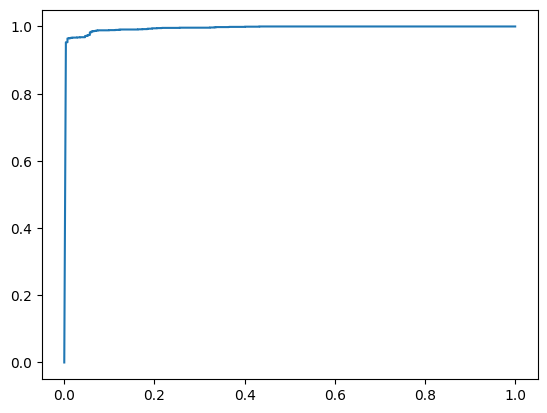

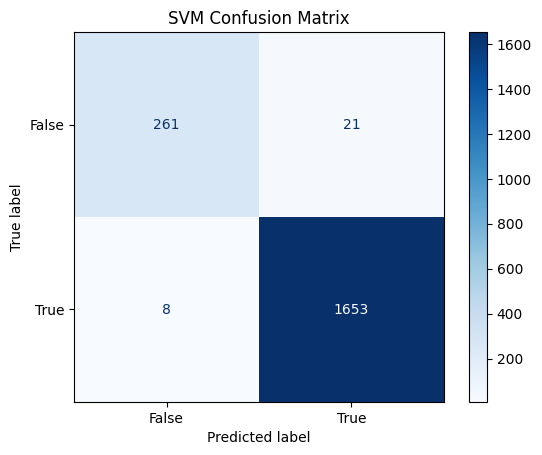


--- Training and Tuning RandomForest ---

📌 RandomForest Results
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Accuracy: 100.0 %
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       282
        True       1.00      1.00      1.00      1661

    accuracy                           1.00      1943
   macro avg       1.00      1.00      1.00      1943
weighted avg       1.00      1.00      1.00      1943



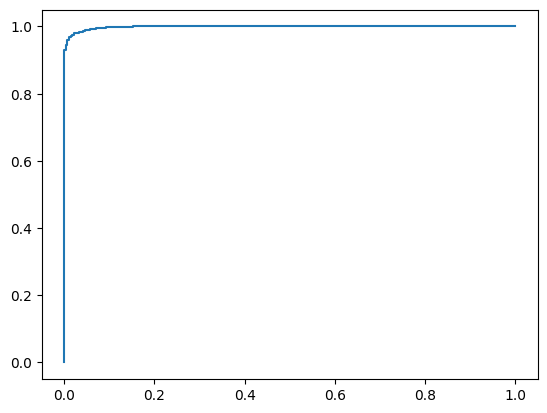

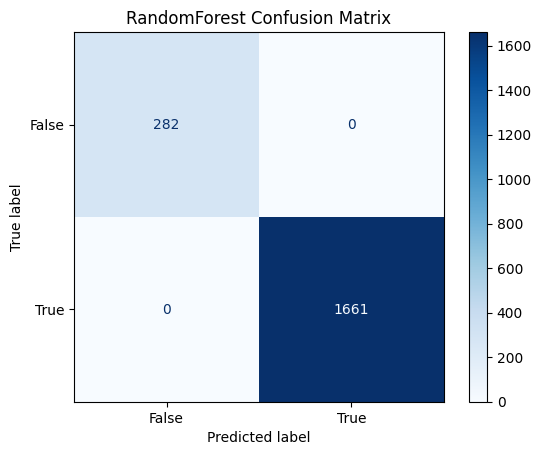


--- Training and Tuning LogisticRegression ---

📌 LogisticRegression Results
Best Parameters: {'C': 1}
Accuracy: 97.84 %
              precision    recall  f1-score   support

       False       0.95      0.90      0.92       282
        True       0.98      0.99      0.99      1661

    accuracy                           0.98      1943
   macro avg       0.97      0.95      0.96      1943
weighted avg       0.98      0.98      0.98      1943



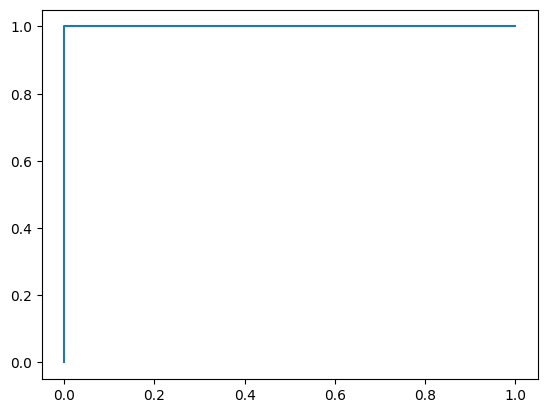

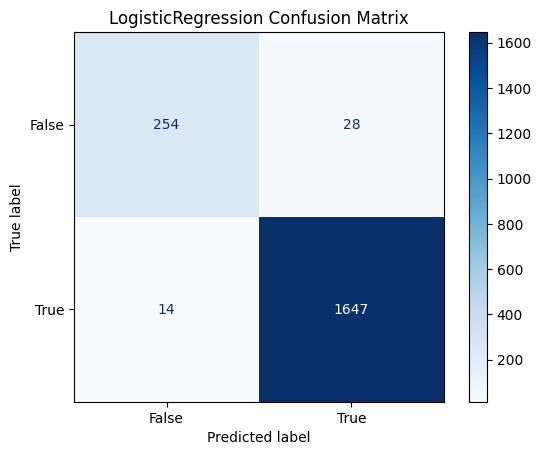


--- Training and Tuning GradientBoosting ---

📌 GradientBoosting Results
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 100.0 %
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       282
        True       1.00      1.00      1.00      1661

    accuracy                           1.00      1943
   macro avg       1.00      1.00      1.00      1943
weighted avg       1.00      1.00      1.00      1943



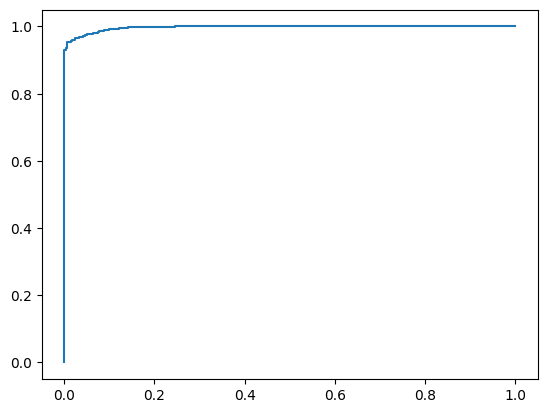

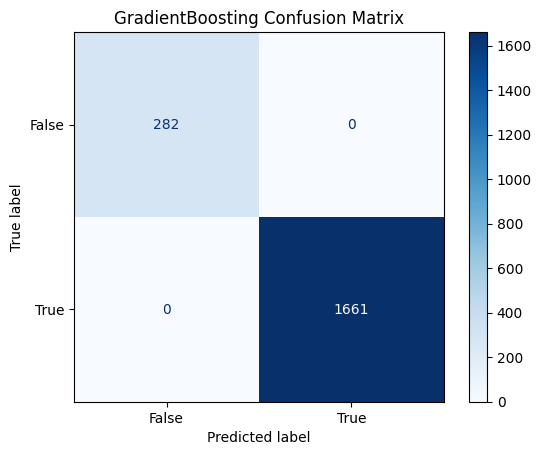

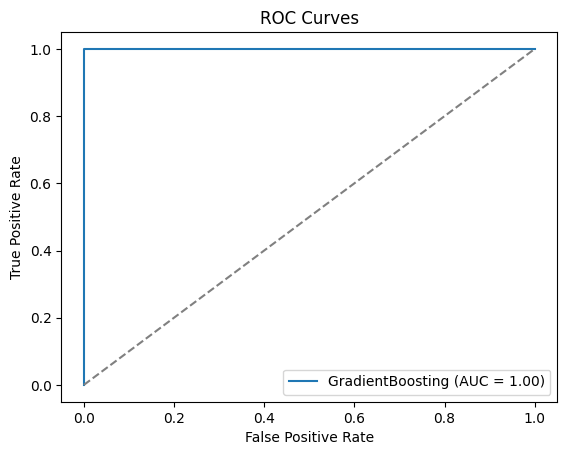


--- Training Ensemble Voting Classifier ---
Ensemble Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       282
        True       1.00      1.00      1.00      1661

    accuracy                           1.00      1943
   macro avg       1.00      1.00      1.00      1943
weighted avg       1.00      1.00      1.00      1943



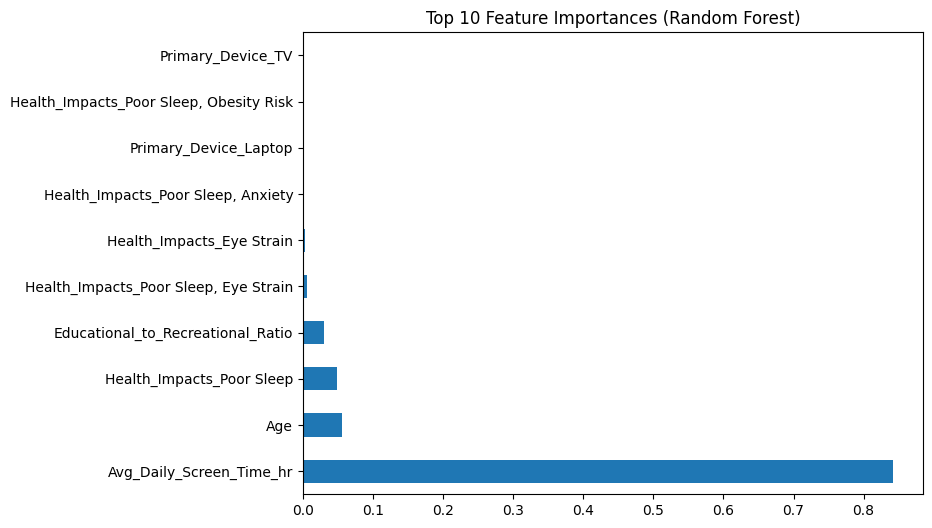

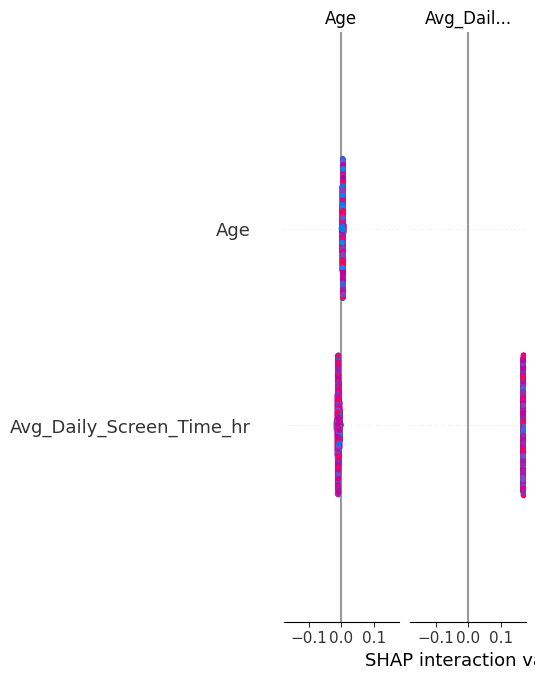

In [1]:
# ================================================
# 📌 Indian Kids Screen Time Analysis + Advanced Classifiers + Explainability
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import shap
from google.colab import files # Keep import for file upload option
import io

# -------------------------------
# Load dataset
try:
    uploaded = files.upload()
    uploaded_filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[uploaded_filename]))
    print(f"✅ Dataset '{uploaded_filename}' loaded successfully via upload!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    df = None

# -------------------------------
if df is not None:
    print("\nDataset shape:", df.shape)
    display(df.head())

    # -------------------------------
    # Data Preprocessing
    target = "Exceeded_Recommended_Limit"
    y = df[target]
    X = df.drop(columns=[target])

    if 'Health_Impacts' in X.columns:
        X.loc[:, 'Health_Impacts'] = X['Health_Impacts'].fillna(X['Health_Impacts'].mode()[0])

    categorical_cols_for_encoding = X.select_dtypes(include=['object', 'category']).columns.tolist()
    X_encoded = pd.get_dummies(X, columns=categorical_cols_for_encoding, drop_first=False)

    if y.dtype == 'object' or y.dtype == 'bool':
        le = LabelEncoder()
        y_enc = le.fit_transform(y)
        target_names = [str(name) for name in le.classes_]
    else:
        y_enc = y
        target_names = None

    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_enc, test_size=0.2, random_state=42, stratify=y_enc if target_names is not None else None
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------------------------------
    # Define Models + Hyperparameter Grids
    models = {
        "KNN": GridSearchCV(
            KNeighborsClassifier(),
            param_grid={"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]},
            cv=5, scoring="accuracy"
        ),
        "SVM": GridSearchCV(
            SVC(probability=True),
            param_grid={"C": [0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": ["scale", "auto"]},
            cv=5, scoring="accuracy"
        ),
        "RandomForest": GridSearchCV(
            RandomForestClassifier(random_state=42),
            param_grid={"n_estimators": [100, 200], "max_depth": [None, 5, 10]},
            cv=5, scoring="accuracy"
        ),
        "LogisticRegression": GridSearchCV(
            LogisticRegression(max_iter=1000),
            param_grid={"C": [0.1, 1, 10]},
            cv=5, scoring="accuracy"
        ),
        "GradientBoosting": GridSearchCV(
            GradientBoostingClassifier(random_state=42),
            param_grid={"n_estimators": [100, 200], "learning_rate": [0.05, 0.1], "max_depth": [3, 5]},
            cv=5, scoring="accuracy"
        )
    }

    # -------------------------------
    # Train and Evaluate
    results = {}
    plt.figure(figsize=(10, 7))
    for name, model in models.items():
        print(f"\n--- Training and Tuning {name} ---")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        results[name] = {"Best Params": model.best_params_, "Accuracy": acc}

        print(f"\n📌 {name} Results")
        print("Best Parameters:", model.best_params_)
        print("Accuracy:", round(acc*100,2), "%")
        print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot(cmap="Blues")
        plt.title(f"{name} Confusion Matrix")
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0,1],[0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

    # -------------------------------
    # Ensemble Voting Classifier
    print("\n--- Training Ensemble Voting Classifier ---")
    voting = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000, C=1)),
            ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=200, random_state=42))
        ], voting='soft'
    )
    voting.fit(X_train_scaled, y_train)
    y_pred_v = voting.predict(X_test_scaled)
    print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_v))
    print(classification_report(y_test, y_pred_v, target_names=target_names))

    # -------------------------------
    # Feature Importances (for tree-based models)
    rf = models["RandomForest"].best_estimator_
    feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh', figsize=(8,6))
    plt.title("Top 10 Feature Importances (Random Forest)")
    plt.show()

    # -------------------------------
    # SHAP Explainability (Novelty)
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

else:
    print("❌ Dataframe 'df' was not created due to file loading error.")
